# loss_function_demonstration.ipynb
## Author: Connacher Murphy

Demonstrates some of the features of check loss and smooth check loss.

### To do:
| Task | Status | Notes |
|-|-|-|
|  |  |  |

## 0. Load Required Libraries

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import quantile_dnn as qdnn

## 1. Plot the check loss function for various $\tau$ values

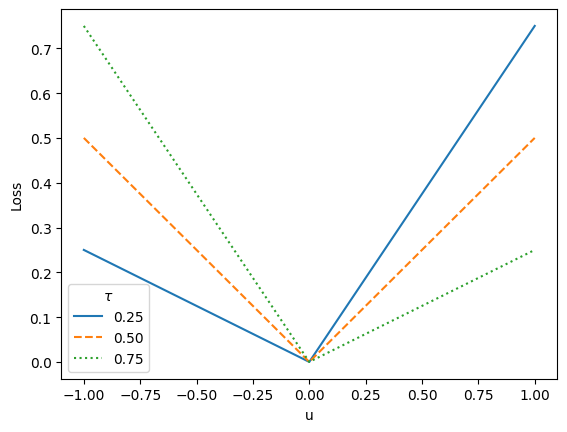

In [80]:
errors = np.arange(-1.0, 1.01, 0.01)
taus = [0.25, 0.5, 0.75]
linestyles = ["-", "--", ":"]

for tau, linestyle in zip(taus, linestyles):
    loss = []
    for error in errors:
        loss.append(qdnn.check_loss(torch.tensor(error), torch.tensor(0.0), tau))

    loss = np.array(loss)
    plt.plot(errors, loss, linestyle=linestyle, label="{:.2f}".format(tau))

plt.xlabel("u")
plt.ylabel("Loss")
plt.legend(title="$\\tau$")
plt.savefig("../out/loss_function_demonstration/check_loss.png", bbox_inches="tight")
plt.show()

## 2. Compare check loss and smooth check loss

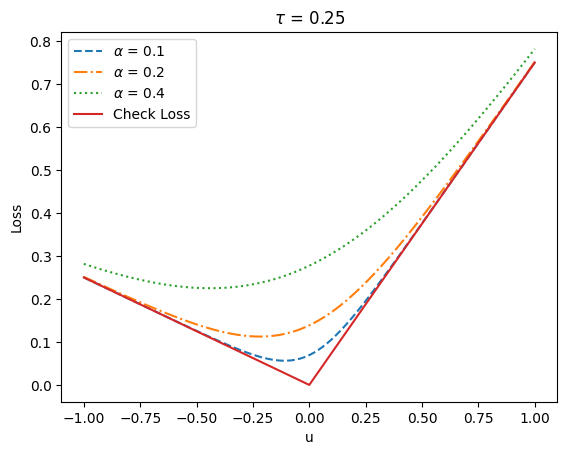

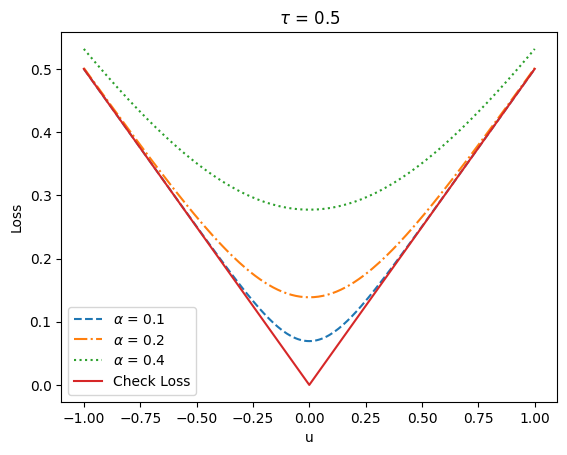

In [81]:
# Scalar values of u for the loss function
errors = np.arange(-1.0, 1.01, 0.01)

# Loss function parameters
taus = [0.25, 0.50]
alphas = [0.1, 0.2, 0.4]

# Line styles for smooth check loss
linestyles = ["--", "-.", ":"]

# Loop over quantiles
for tau in taus:
    # Store values of loss function
    loss_check = []
    loss_smooth_check = [[] for _ in range(len(alphas))]

    # Loop over errors
    for error in errors:
        # Compute check loss
        loss_check.append(qdnn.check_loss(torch.tensor(error), torch.tensor(0.0), tau))

        # Loop over smoothing parameter values
        for i in range(len(alphas)):
            alpha = alphas[i]  # grab parameter value

            loss_smooth_check[i].append(  # store loss function value
                qdnn.smooth_check_loss(
                    torch.tensor(error), torch.tensor(0.0), tau, alpha=alpha
                )
            )

    # Plot the loss functions
    for i in range(len(alphas)):
        alpha = alphas[i]

        plt.plot(
            errors,
            loss_smooth_check[i],
            linestyle=linestyles[i],
            label=f"$\\alpha$ = {alpha}",
        )

    plt.plot(errors, loss_check, label="Check Loss")
    plt.legend()
    plt.title(f"$\\tau$ = {tau}")
    plt.xlabel("u")
    plt.ylabel("Loss")
    plt.savefig(
        f"../out/loss_function_demonstration/smooth_check_loss_tau_{int(tau * 100)}.png",
        bbox_inches="tight",
    )
    plt.show()

## 3. Test the loss functions on unconditional quantiles

In [82]:
def sample_loss(N, target, tau, truth, num_candidates, alphas, colors, filename):
    """
    Calculate in-sample loss for various candidate quantiles
    Arguments:
        N: number of observations
        target: uniform draws
        tau: quantile
        num_candidates: number of quantile candidates
    """

    # Set of quantiles
    step_size = 1 / num_candidates
    candidates = np.arange(0.0, 1.0 + step_size, step_size)

    # Calculate loss for various quantile candidates
    loss_check = []
    loss_smooth_check = [[] for _ in range(len(alphas))]

    for candidate in candidates:
        input = candidate * torch.ones(N)  # quantile candidate

        # Compute check loss
        loss_check.append(qdnn.check_loss(input, target, tau).item())

        # Compute smooth check loss for various smoothing parameter values
        for i in range(len(alphas)):
            alpha = alphas[i]  # grab parameter value

            loss_smooth_check[i].append(  # store loss function value
                qdnn.smooth_check_loss(input, target, tau, alpha=alpha)
            )

    # Plot the true quantile as a vertical line
    plt.axvline(x=truth, color="tab:gray", zorder=1)

    # Add smooth check loss to plot
    for i in range(len(alphas)):
        plt.plot(  # plot loss function
            candidates,
            loss_smooth_check[i],
            color=colors[i],
            linestyle=linestyles[i],
            label=f"$\\alpha$ = {alphas[i]}",
        )
        index_min_loss = np.argmin(loss_smooth_check[i])  # find empirical minimum
        plt.scatter(
            candidates[index_min_loss],
            loss_smooth_check[i][index_min_loss],
            color=colors[i],
            marker="p",
            s=60,
            label="Empirical minimum",
        )

    # Add check loss to plot
    plt.plot(candidates, loss_check, color="tab:red", label="Check Loss")
    index_min_loss = np.argmin(loss_check)  # find empirical minimum
    plt.scatter(
        candidates[index_min_loss],
        loss_check[index_min_loss],
        color="tab:red",
        marker="p",
        s=60,
        label="Empirical minimum",
    )

    # Final graph additions
    plt.xlabel("Quantile candidate")
    plt.ylabel("Loss")
    plt.title(f"Loss under $\\tau$ = {tau}")
    plt.legend()
    plt.savefig(
        f"../out/loss_function_demonstration/unconditional_quantiles_{int(tau * 100)}_{filename}.png",
        bbox_inches="tight",
    )
    plt.show()

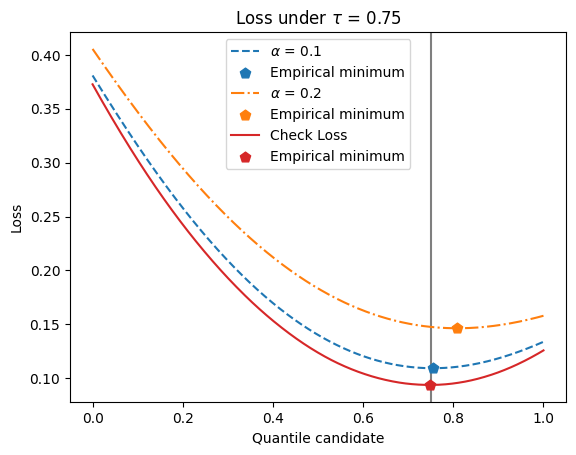

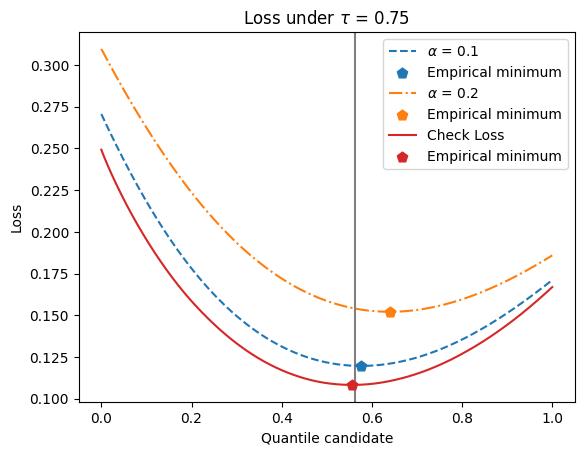

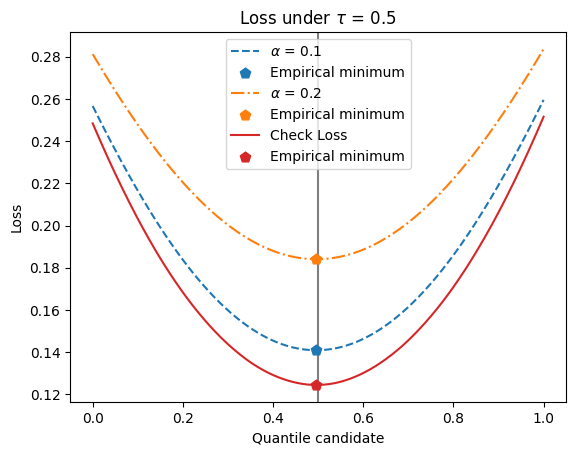

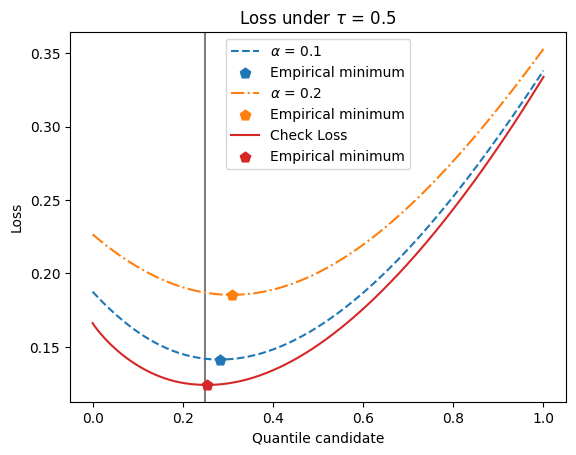

In [83]:
# Set the seed for reproducibility
np.random.seed(123)

# N draws from uniform distribution on [0, 1]
N = 10000
target = torch.rand(N)

# Uniform draws squared
target_sq = torch.rand(N) ** 2

# Number of quantile candidates
num_candidates = 1000

# Smoothing parameter values (and associated styling)
alphas = [0.1, 0.2]
colors = ["tab:blue", "tab:orange"]
linestyles = ["--", "-."]

taus = [0.75, 0.50]  # loop over quantiles
for tau in taus:
    sample_loss(N, target, tau, tau, num_candidates, alphas, colors, "unif")
    sample_loss(N, target_sq, tau, tau ** 2, num_candidates, alphas, colors, "unif_sq")